# Installations


UniChart Finetuning on ChartQA Dataset - IndoChart

Notebook ini menggabungkan semua kode yang diperlukan untuk melakukan fine-tuning model UniChart pada dataset ChartQA. Terdiri dari:

- Persiapan dataset
- Konfigurasi model
- Setup training
- Eksekusi training

In [1]:
import os
os.environ["HF_HOME"] = "/media/storage/alif/huggingface"

In [ ]:
# !pip install -q datasets
# !pip install -q bitsandbytes-cuda112
# !pip install -q accelerate
# !pip install -q peft
# !pip install -q torch torchvision torchaudio
# !pip install -q huggingface-hub
# !pip install -q tensorboard
# !pip install -q --upgrade transformers pytorch-lightning
# !pip install -q rouge-score nltk
# !pip install -q pycocoevalcap

# Import Library

In [2]:
# ------------------ Import Library ------------------
import io
import json
import os
import random
import math
import re
from pathlib import Path
from typing import Any, List, Tuple

import numpy as np
from PIL import Image
from nltk import edit_distance

import torch
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning.utilities import rank_zero_only
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from pycocoevalcap.cider.cider import Cider

from transformers import DonutProcessor, VisionEncoderDecoderModel, BartConfig, VisionEncoderDecoderConfig
from datasets import load_dataset

In [3]:
# ------------------ Part 1: ChartQA Dataset Class ------------------
# Kelas ini menangani loading dan preprocessing dataset ChartQA.
added_tokens = []

class ChartQADataset(Dataset):
    """
    Dataset class for ChartQA data handling
    """
    def __init__(
        self,
        dataset_split,
        max_length: int,
        processor: DonutProcessor = None,
        split: str = "train",
        ignore_id: int = -100,
        prompt_end_token: str = None,
        task_prefix: str = '<opencqa>',
    ):
        super().__init__()

        # Filter dataset berdasarkan split
        self.dataset = dataset_split
        self.dataset_length = len(self.dataset)

        self.prompt_end_token = prompt_end_token 
        self.max_length = max_length
        self.split = split
        self.ignore_id = ignore_id
        self.processor = processor
        self.prompt_end_token_id = self.processor.tokenizer.convert_tokens_to_ids(self.prompt_end_token)
        self.task_prefix = task_prefix

    def __len__(self) -> int:
        return self.dataset_length

    def __getitem__(self, idx: int):
        sample = self.dataset[idx]

        # input_tensor: decode gambar dari bytes
        image = Image.open(io.BytesIO(sample['image'])).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt", legacy=False).pixel_values
        input_tensor = pixel_values.squeeze()

        # input_ids: proses string input
        processed_parse = self.task_prefix + " " + sample['query'] + " " + self.prompt_end_token + " " + sample['label'] + self.processor.tokenizer.eos_token
        input_ids = self.processor.tokenizer(
            processed_parse,
            add_special_tokens=False,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )["input_ids"].squeeze(0)

        if self.split == "train":
            labels = input_ids.clone()
            labels[labels == self.processor.tokenizer.pad_token_id] = self.ignore_id                  # model doesn't need to predict pad token
            labels[: torch.nonzero(labels == self.prompt_end_token_id).sum() + 1] = self.ignore_id    # model doesn't need to predict prompt 
            return input_tensor, input_ids, labels
        else:
            prompt_end_index = torch.nonzero(input_ids == self.prompt_end_token_id).sum()             # return prompt end index instead of target output labels
            return input_tensor, input_ids, prompt_end_index, processed_parse

In [5]:
# ------------------ Part 2: ChartQA Lightning Module ------------------
# Modul PyTorch Lightning yang menangani proses training.
class ChartQAModule(pl.LightningModule):
    def __init__(self, config, processor, model, args, train_dataset, val_dataset):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.args = args
        self.validation_step_outputs = []

        self.rouge_scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
        self.smoother = SmoothingFunction()

    def training_step(self, batch, batch_idx):
        pixel_values, decoder_input_ids, labels = batch
        
        outputs = self.model(pixel_values,
                             decoder_input_ids=decoder_input_ids[:, :-1],
                             labels=labels[:, 1:])
        loss = outputs.loss
        self.log_dict({"train_loss": loss}, sync_dist=True)
        return loss
    
    def extract_numbers(self, text):
        """Extract all numbers from text as list of ints"""
        return list(map(int, re.findall(r'\d+', str(text))))

    def compute_relaxed_accuracy(self, gt_text, pred_text, tolerance=0.05):
        """Compare numbers in gt and pred with tolerance (can handle different lengths)"""
        gt_numbers = self.extract_numbers(gt_text)
        pred_numbers = self.extract_numbers(pred_text)

        matched = 0
        used_indices = set()

        for gt in gt_numbers:
            for i, pred in enumerate(pred_numbers):
                if i in used_indices:
                    continue
                if abs(gt - pred) / max(gt, 1) <= tolerance:
                    matched += 1
                    used_indices.add(i)
                    break  # Match found, move to next ground truth number

        return matched / len(gt_numbers) if gt_numbers else 1.0  # Avoid division by zero

    def compute_metric(self, gt, pred):
        metrics = {}

        # 1. Relaxed Accuracy
        try:
            metrics['relaxed_acc'] = self.compute_relaxed_accuracy(gt, pred)
        except:
            metrics['relaxed_acc'] = 0.0

        # 2. BLEU Score
        try:
            reference = [str(gt).lower().split()]
            candidate = str(pred).lower().split()
            metrics['bleu'] = sentence_bleu(
                reference,
                candidate,
                smoothing_function=self.smoother.method4
            )
        except:
            metrics['bleu'] = 0.0

        # 3. ROUGE Score
        try:
            scores = self.rouge_scorer.score(str(gt).lower(), str(pred).lower())
            metrics['rougeL'] = scores['rougeL'].fmeasure
        except:
            metrics['rougeL'] = 0.0

        return metrics

    def validation_step(self, batch, batch_idx):
        pixel_values, decoder_input_ids, prompt_end_idxs, answers = batch

        decoder_prompts = pad_sequence(
            [input_id[: end_idx + 1] for input_id, end_idx in zip(decoder_input_ids, prompt_end_idxs)],
            batch_first=True,
        )

        outputs = self.model.generate(
            pixel_values,
            decoder_input_ids=decoder_prompts,
            max_length=self.args.max_length,
            early_stopping=True,
            pad_token_id=self.processor.tokenizer.pad_token_id,
            eos_token_id=self.processor.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=4,
            bad_words_ids=[[self.processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
        )

        predictions = [
            seq.replace(self.processor.tokenizer.eos_token, "")
            .replace(self.processor.tokenizer.pad_token, "")
            .strip()
            for seq in self.processor.tokenizer.batch_decode(outputs.sequences)
        ]

        # Process predictions and answers
        processed_preds = []
        processed_answers = []
        relaxed_accuracies = []
        bleus = []
        rougeLs = []

        for pred, answer in zip(predictions, answers):
            # Ekstraksi jawaban model
            pred_parts = pred.split("<s_answer>")
            pred_part = pred_parts[1].strip() if len(pred_parts) >= 2 else ""

            # Bersihkan token
            pred_part = pred_part.replace("</s>", "").replace("<s>", "").strip()

            # Jawaban ground truth
            answer_parts = answer.split("<s_answer>")
            answer_part = answer_parts[1].strip() if len(answer_parts) >= 2 else ""

            # Simpan hasil bersih
            processed_preds.append(pred_part)
            processed_answers.append(answer_part)

            # Hitung metrik
            metrics = self.compute_metric(answer_part, pred_part)
            relaxed_accuracies.append(metrics['relaxed_acc'])
            bleus.append(metrics['bleu'])
            rougeLs.append(metrics['rougeL'])

        # Log metrik rata-rata per batch
        self.log_dict({
            "val_relaxed_acc": sum(relaxed_accuracies) / len(relaxed_accuracies),
            "val_bleu": sum(bleus) / len(bleus),
            "val_rougeL": sum(rougeLs) / len(rougeLs),
        }, prog_bar=True, sync_dist=True)

        return {
            "preds": processed_preds,
            "answers": processed_answers,
            "relaxed_acc": relaxed_accuracies,
            "bleu": bleus,
            "rougeL": rougeLs
        }

    def configure_optimizers(self):
        max_iter = None

        if int(self.config.get("max_epochs", -1)) > 0:
            assert len(self.config.get("train_batch_sizes")) == 1, "Set max_epochs hanya jika jumlah dataset adalah 1"
            max_iter = (self.config.get("max_epochs") * self.config.get("num_training_samples_per_epoch")) / (
                self.config.get("train_batch_sizes")[0] * torch.cuda.device_count() * self.config.get("num_nodes", 1)
            )

        if int(self.config.get("max_steps", -1)) > 0:
            max_iter = min(self.config.get("max_steps"), max_iter) if max_iter is not None else self.config.get("max_steps")

        assert max_iter is not None
        optimizer = torch.optim.Adam(self.parameters(), lr=self.config.get("lr"))
        scheduler = {
            "scheduler": self.cosine_scheduler(optimizer, max_iter, self.config.get("warmup_steps")),
            "name": "learning_rate",
            "interval": "step",
        }
        return [optimizer], [scheduler]

    @staticmethod
    def cosine_scheduler(optimizer, training_steps, warmup_steps):
        def lr_lambda(current_step):
            if current_step < warmup_steps:
                return current_step / max(1, warmup_steps)
            progress = current_step - warmup_steps
            progress /= max(1, training_steps - warmup_steps)
            return max(0.0, 0.5 * (1.0 + math.cos(math.pi * progress)))
        return LambdaLR(optimizer, lr_lambda)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.args.batch_size, shuffle=True, num_workers=self.args.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.args.valid_batch_size, shuffle=False, num_workers=self.args.num_workers)

    @rank_zero_only
    def on_save_checkpoint(self, checkpoint):
        save_path = os.path.join(self.config['result_path'], 'chartqa-checkpoint-epoch=' + str(self.current_epoch) + '-' + str(self.global_step))
        # self.model.save_pretrained(save_path)
        # self.processor.save_pretrained(save_path)

In [6]:
# ------------------ Part 3: Training Configuration ------------------
# Mengatur parameter yang awalnya diberikan melalui ArgumentParser
class Args:
    def __init__(self):
        self.data_path = "akunskripsiapillv1/indochart-v2-dataset"  # Path ke file data
        self.output_dir = "/media/storage/alif/checkpoints"  # Path untuk menyimpan checkpoint
        self.max_epochs = 2  # Jumlah maksimum epoch
        self.batch_size = 2  # Batch size untuk training
        self.valid_batch_size = 2  # Batch size untuk validasi
        self.max_length = 512  # Maksimal panjang untuk decoder generation
        self.num_workers = 2  # Jumlah worker
        self.lr = 5e-5  # Learning rate
        self.check_val_every_n_epoch = 1  # Validasi setiap n epoch
        self.log_every_n_steps = 50  # Logging setiap n steps
        self.warmup_steps = 50  # Jumlah warmup steps
        self.checkpoint_steps = 1000  # Interval checkpoint
        self.gradient_clip_val = 1.0  # Nilai clip gradient
        self.accumulate_grad_batches = 1  # Akumulasi grad batches
        self.gpus_num = 1  # Jumlah GPU
        self.nodes_num = 1  # Jumlah nodes
        self.checkpoint_path = "ahmed-masry/unichart-base-960"  # Path checkpoint
        self.save_every_n_epochs = 1  # Simpan checkpoint setiap n epoch

# Buat instance args
args = Args()

In [7]:
# ------------------ Part 4: Main Training Function ------------------
# Buat direktori output jika belum ada
os.makedirs(args.output_dir, exist_ok=True)
    
# Load processor dan model
print(f"Loading processor and model from {args.checkpoint_path}...")
processor = DonutProcessor.from_pretrained(args.checkpoint_path)
model = VisionEncoderDecoderModel.from_pretrained(args.checkpoint_path)

# Load dataset
print(f"Loading dataset from {args.data_path}...")
dataset = load_dataset(args.data_path)

# Persiapkan dataset training
print("Preparing training dataset...")
train_dataset = ChartQADataset(
    dataset["train"],  # Menggunakan split train
    max_length=args.max_length,
    processor=processor,
    split="train",
    prompt_end_token="<s_answer>",
    task_prefix="<opencqa>"
)

# Persiapkan dataset validasi
print("Preparing validation dataset...")
val_dataset = ChartQADataset(
    dataset["validation"],  # Menggunakan split validasi
    max_length=args.max_length,
    processor=processor,
    split="validation",
    prompt_end_token="<s_answer>",
    task_prefix="<opencqa>"
)

# Konfigurasi training
config = {
    "max_epochs": args.max_epochs,
    "check_val_every_n_epoch": args.check_val_every_n_epoch,
    "log_every_n_steps": args.log_every_n_steps,
    "gradient_clip_val": args.gradient_clip_val,
    "num_training_samples_per_epoch": len(dataset["train"]),
    "lr": args.lr,
    "train_batch_sizes": [args.batch_size],
    "val_batch_sizes": [args.valid_batch_size],
    "num_nodes": args.nodes_num,
    "warmup_steps": args.warmup_steps,
    "result_path": args.output_dir,
    "verbose": True,
}

# Inisialisasi module ChartQA
print("Initializing ChartQA module...")
model_module = ChartQAModule(config, processor, model, args, train_dataset, val_dataset)
    
# Setup checkpoint callback
checkpoint_callback = ModelCheckpoint(
    dirpath=args.output_dir, 
    every_n_epochs=args.save_every_n_epochs, 
    save_last=False, 
    save_top_k=-1
)

# Create CSV logger
csv_logger = CSVLogger(
    save_dir=args.output_dir,
    name="unichart-indochart-v2",
    version=None
)

# Inisialisasi trainer PyTorch Lightning
print("Setting up PyTorch Lightning trainer...")
trainer = pl.Trainer(
    accelerator="gpu",
    devices=args.gpus_num,
    max_epochs=args.max_epochs,
    check_val_every_n_epoch=args.check_val_every_n_epoch,
    log_every_n_steps=args.log_every_n_steps,
    gradient_clip_val=args.gradient_clip_val,
    num_nodes=args.nodes_num,
    precision="16-mixed",
    default_root_dir=args.output_dir,
    callbacks=[checkpoint_callback],
    logger=csv_logger,
)

Loading processor and model from ahmed-masry/unichart-base-960...


Config of the encoder: <class 'transformers.models.donut.modeling_donut_swin.DonutSwinModel'> is overwritten by shared encoder config: DonutSwinConfig {
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    14,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": [
    960,
    960
  ],
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-05,
  "mlp_ratio": 4.0,
  "model_type": "donut-swin",
  "num_channels": 3,
  "num_heads": [
    4,
    8,
    16,
    32
  ],
  "num_layers": 4,
  "patch_size": 4,
  "path_norm": true,
  "qkv_bias": true,
  "transformers_version": "4.47.0",
  "use_absolute_embeddings": false,
  "window_size": 10
}

Config of the decoder: <class 'transformers.models.mbart.modeling_mbart.MBartForCausalLM'> is overwritten by shared decoder config: MBartConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "add_f

Loading dataset from akunskripsiapillv1/indochart-v2-dataset...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Preparing training dataset...
Preparing validation dataset...
Initializing ChartQA module...
Setting up PyTorch Lightning trainer...


In [8]:
# Mulai proses training
import time
print("Starting training...")

start = time.time()
trainer.fit(model_module)
end = time.time()

duration = end - start
print(f"Training time: {duration:.2f} seconds")

print("Training completed!")


You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/media/storage/alif/mychart/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/storage/alif/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting training...



  | Name  | Type                      | Params | Mode
-----------------------------------------------------------
0 | model | VisionEncoderDecoderModel | 201 M  | eval
-----------------------------------------------------------
201 M     Trainable params
0         Non-trainable params
201 M     Total params
807.433   Total estimated model params size (MB)
0         Modules in train mode
484       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/media/storage/alif/mychart/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


Training time: 7750.72 seconds
Training completed!


In [ ]:
from huggingface_hub import create_repo, login

hf_token="HF_TOKEN"
login(hf_token)

# Define model and processor
model = model_module.model
processor = model_module.processor

# Define the repository name where you want to upload the model
repo_name = "akunskripsiapillv1/finetuned-unichart-indochart-v2"

# Create the repo (if it doesn't exist)
create_repo(repo_name, exist_ok=True)

# Push model and processor to Hugging Face Hub
model.push_to_hub(repo_name)
processor.push_to_hub(repo_name)

model.safetensors:   0%|          | 0.00/809M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/akunskripsiapillv1/finetuned-unichart-indochart-v2/commit/d7f2772bcfd56ff61aee19d678860706e5356711', commit_message='Upload processor', commit_description='', oid='d7f2772bcfd56ff61aee19d678860706e5356711', pr_url=None, repo_url=RepoUrl('https://huggingface.co/akunskripsiapillv1/finetuned-unichart-indochart-v2', endpoint='https://huggingface.co', repo_type='model', repo_id='akunskripsiapillv1/finetuned-unichart-indochart-v2'), pr_revision=None, pr_num=None)

: 

In [ ]:
from transformers import DonutProcessor, VisionEncoderDecoderModel
from PIL import Image
import torch

def generate_chart_description(model_name: str, image_path: str, input_prompt: str) -> str:
    # Load model dan processor
    model = VisionEncoderDecoderModel.from_pretrained(model_name, token=hf_token)
    processor = DonutProcessor.from_pretrained(model_name, token=hf_token)

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Load dan proses gambar
    image = Image.open(image_path).convert("RGB")
    pixel_values = processor(image, return_tensors="pt").pixel_values

    # Tokenisasi prompt
    decoder_input_ids = processor.tokenizer(input_prompt, add_special_tokens=False, return_tensors="pt").input_ids

    # Generate output
    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=4,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )

    # Decode hasil output
    sequence = processor.batch_decode(outputs.sequences)[0]
    sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    result = sequence.split("<s_answer>")[1].strip() if "<s_answer>" in sequence else sequence.strip()

    return result

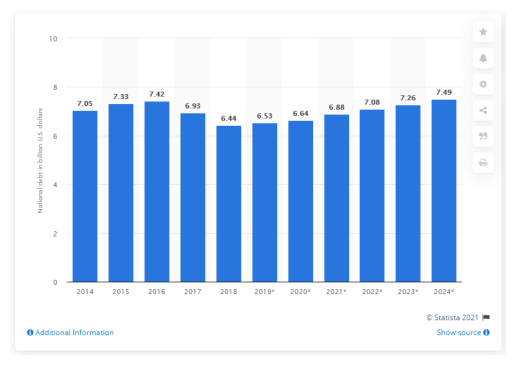

model.safetensors:   0%|          | 0.00/809M [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.donut.modeling_donut_swin.DonutSwinModel'> is overwritten by shared encoder config: DonutSwinConfig {
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    14,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": [
    960,
    960
  ],
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-05,
  "mlp_ratio": 4.0,
  "model_type": "donut-swin",
  "num_channels": 3,
  "num_heads": [
    4,
    8,
    16,
    32
  ],
  "num_layers": 4,
  "patch_size": 4,
  "path_norm": true,
  "qkv_bias": true,
  "transformers_version": "4.47.0",
  "use_absolute_embeddings": false,
  "window_size": 10
}

Config of the decoder: <class 'transformers.models.mbart.modeling_mbart.MBartForCausalLM'> is overwritten by shared decoder config: MBartConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "add_f

Deskripsi Hasil Generate:
Statistik ini menunjukkan perkiraan tahunan nasional di Amerika Serikat dari 2014 hingga 2018, dengan proyeksi hingga 2024. Pada tahun 2018, perkiraan nilai tahunan nasional di AS berjumlah sekitar 6,44 miliar dolar AS.


In [14]:
from PIL import Image
import matplotlib.pyplot as plt

# Parameter
model_name = "akunskripsiapillv1/finetuned-unichart-indochart-v2"
image_path = "/media/storage/alif/mychart/13308.png"
input_prompt = "<opencqa> Buatkan deskripsi dari grafik berikut ini secara lengkap dan informatif <s_answer>"

# Tampilkan gambar
image = Image.open(image_path).convert("RGB")
plt.imshow(image)
plt.axis('off')
plt.show()

# Generate deskripsi
description = generate_chart_description(model_name, image_path, input_prompt)
print("Deskripsi Hasil Generate:")
print(description)